In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# Reload cleaned data
df = pd.read_csv("cleaned_data2.csv")

# make sure the cleaned data is still clean
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]
df = df[~df["Invoice"].astype(str).str.contains("C", na=False)]
df.dropna(subset=['Customer ID'], inplace=True)
df["Total_Price"] = df["Quantity"] * df["Price"]

In [2]:
'''In this chapter, I am going to some changes to the dataset.
Then I am going to create df_cltv and then apply the two models.
They are BetaGeoFitter and GammaGammaFitter models.
I am going to use the BetaGeoFilter model to predict how often shop of customer.
I am going to use the GammaGammaFilter model to predict how much profit a customer will bring.
And then I am going to analyze the data.'''
#Lets begin the mathematical operations for CLTV analysis.

'In this chapter, I am going to some changes to the dataset.\nThen I am going to create df_cltv and then apply the two models.\nThey are BetaGeoFitter and GammaGammaFitter models.\nI am going to use the BetaGeoFilter model to predict how often shop of customer.\nI am going to use the GammaGammaFilter model to predict how much profit a customer will bring.\nAnd then I am going to analyze the data.'

In [3]:
#AGAIN we will use this dataset for CLTV analysis, so we load it here to use cleaned data directly.
cleaned_data2 = df.copy()
print("🚀 ready for RFM analysis!")
cleaned_data2.head()

🚀 ready for RFM analysis!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


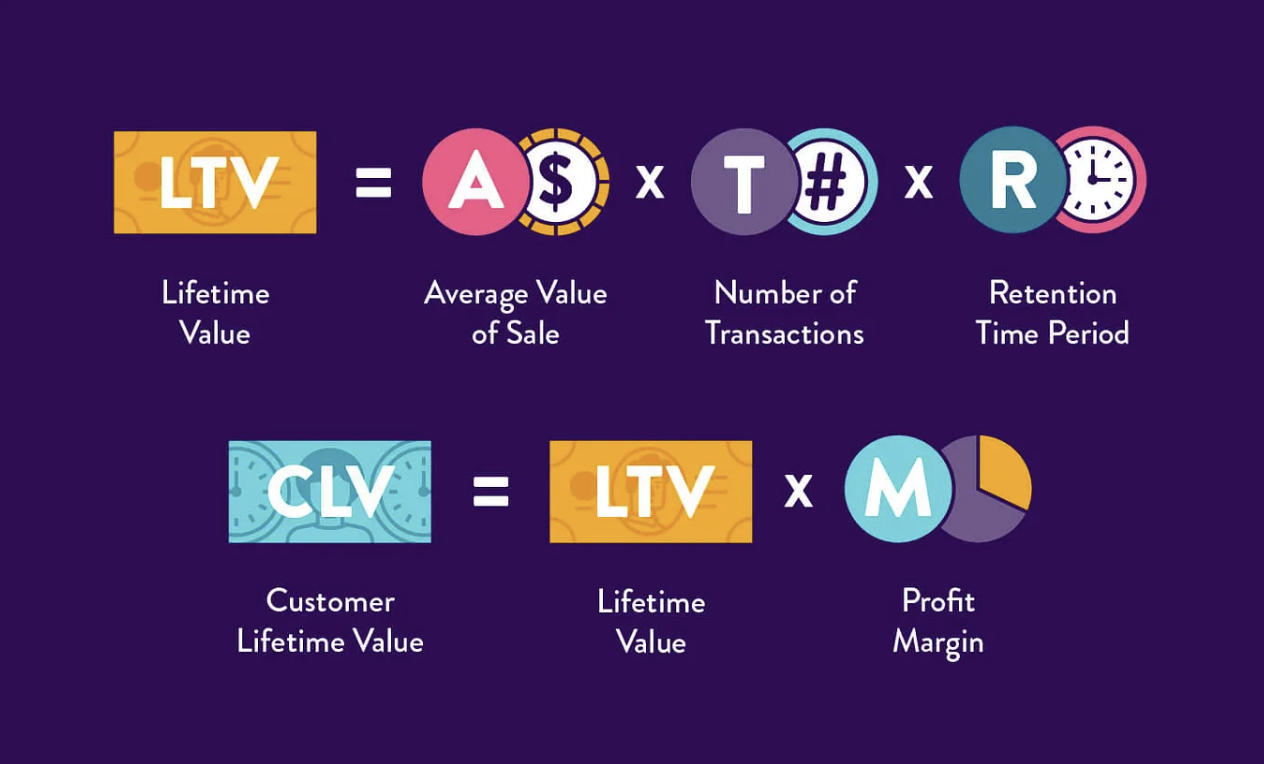

In [4]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

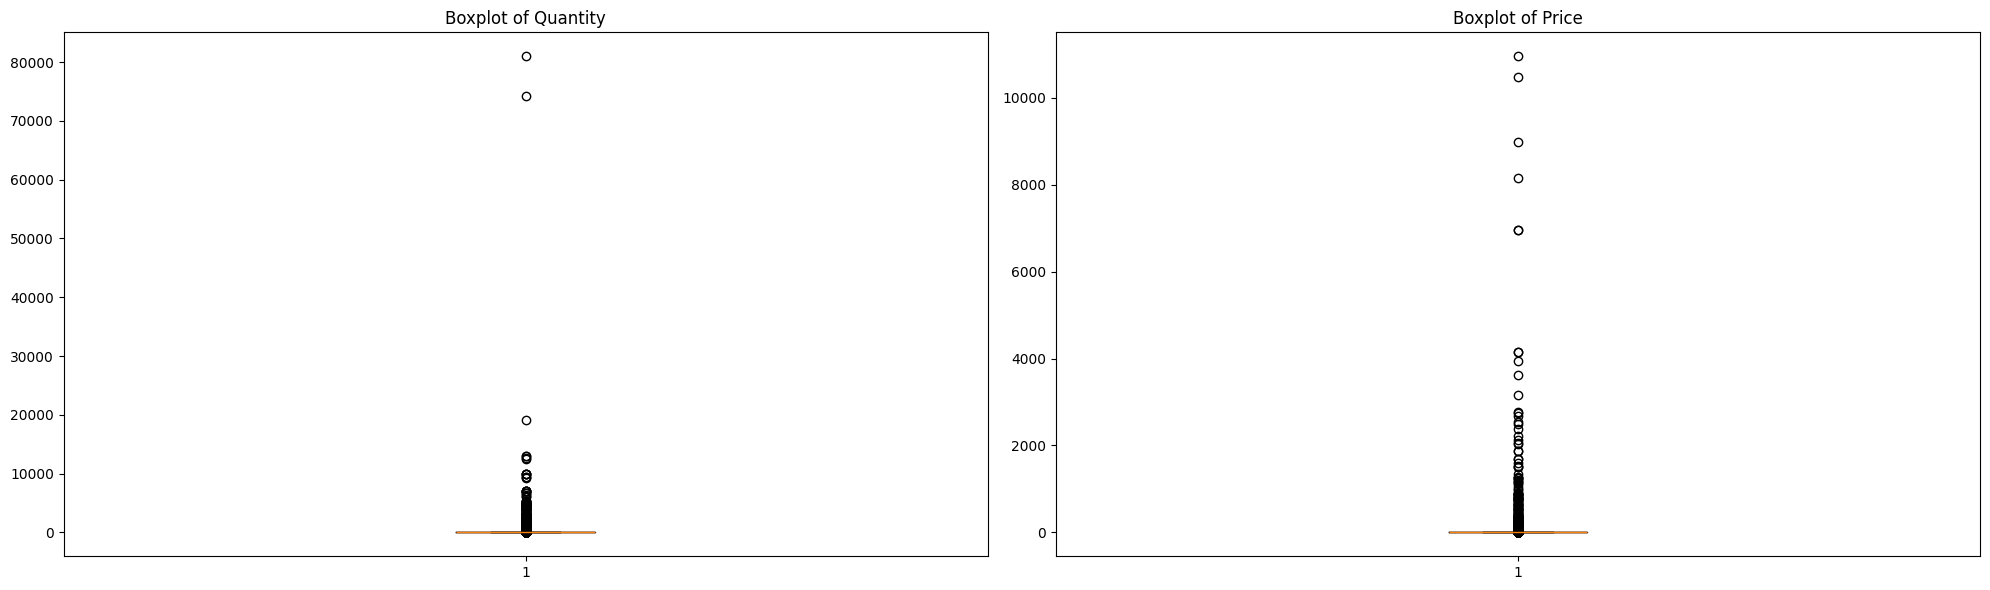

In [5]:
# we can look at the boxplots of Quantity and Price to see the outliers
# before applying the outlier treatment
f, ax = plt.subplots(1, 2, figsize=(20, 6)) 
col_list = ["Quantity", "Price"]

for i in range(0, 2):
    ax[i].boxplot(cleaned_data2[col_list[i]], vert=0)
    ax[i].set_title(f"Boxplot of {col_list[i]}")

plt.tight_layout() 
plt.show()

In [6]:
replace_with_threshold(cleaned_data2, "Quantity")
replace_with_threshold(cleaned_data2, "Price")

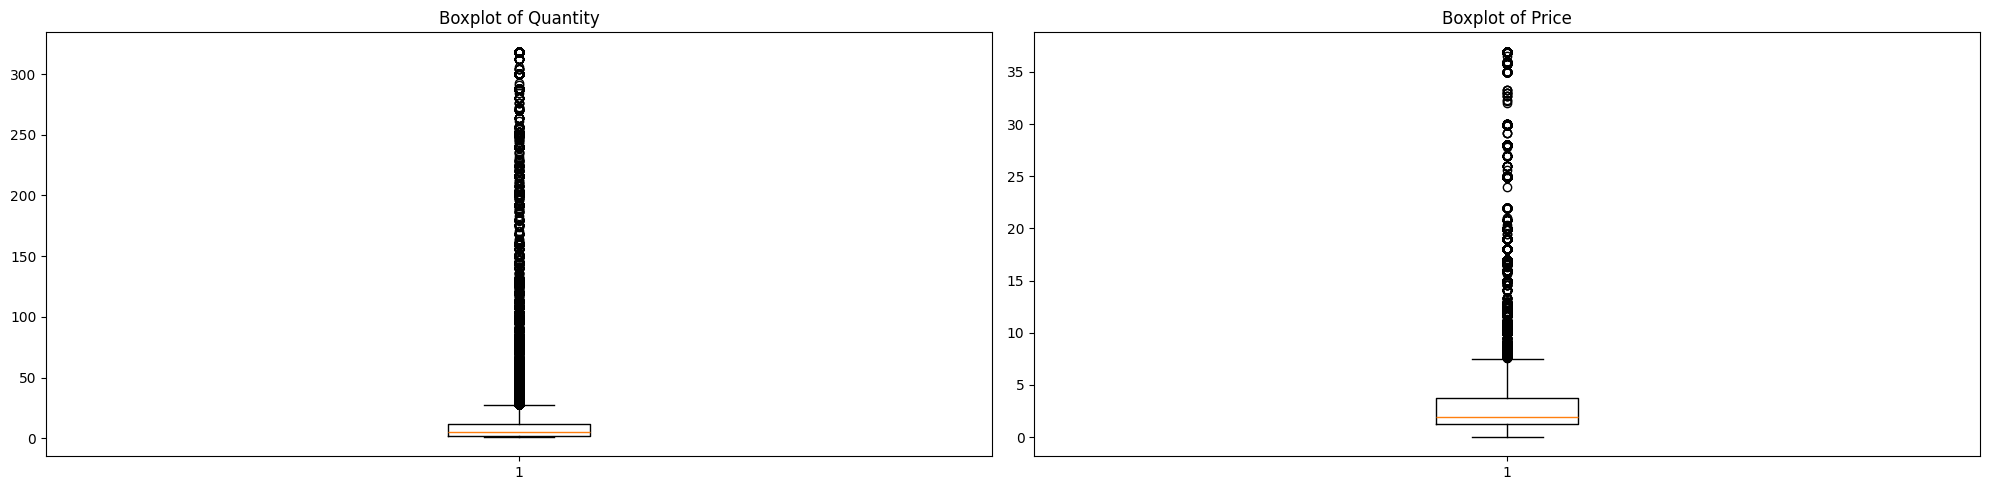

In [7]:
# Subplot düzenini 1 satır, 2 sütun (1, 2) yaparak yan yana diziyoruz.
f, ax = plt.subplots(1, 2, figsize=(20, 5)) 
col_list = ["Quantity", "Price"]

for i in range(0, 2):
    # vert=0 boxplot'un kendisini yatay yapar, (1, 2) ise yerleşimi yan yana yapar.
    ax[i].boxplot(cleaned_data2[col_list[i]], vert=0)
    ax[i].set_title(f"Boxplot of {col_list[i]}")

plt.tight_layout() # Grafiklerin birbirine girmesini önler.
plt.show()

In [8]:
#Prepare CLTV DataFrame
cleaned_data2["InvoiceDate"].max()


Timestamp('2011-12-09 12:50:00')

In [9]:
'''
Recency: Time since the last purchase. Weekly. (User Specific)
NEW!! T: Customer's age. Weekly. (how long before the analysis date the first purchase was made)
Frequency: Total number of repeat purchases (frequency > 1)
Monetary: Average earnings per purchase
'''

"\nRecency: Time since the last purchase. Weekly. (User Specific)\nNEW!! T: Customer's age. Weekly. (how long before the analysis date the first purchase was made)\nFrequency: Total number of repeat purchases (frequency > 1)\nMonetary: Average earnings per purchase\n"

In [10]:
today_date = dt.datetime(2011, 12, 11)

# Create the df_cltv dataframe.
df_cltv = cleaned_data2.groupby("Customer ID").agg({"InvoiceDate" : [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, # recency
                                                  lambda InvoiceDate: (today_date - InvoiceDate.min()).days], # T
                                         "Invoice" : lambda Invoice: Invoice.nunique(), # frequnecy
                                         "Total_Price": lambda Total_Price: Total_Price.sum()}) # monetary

In [11]:
df_cltv.head()

InvoiceDate             Invoice Total_Price
             <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                            
12346.0             400        726       12    77556.46
12347.0             402        405        8     5633.32
12348.0             362        439        5     2019.40
12349.0             570        590        4     4428.69
12350.0               0        311        1      334.40

In [12]:
# I remove the column names of df_cltv because I am going to change them.
df_cltv.columns = df_cltv.columns.droplevel(0)

In [13]:
df_cltv.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0,400,726,12,77556.46
12347.0,402,405,8,5633.32
12348.0,362,439,5,2019.40
12349.0,570,590,4,4428.69
12350.0,0,311,1,334.40


In [14]:
# I specfy the column name of df_cltv
df_cltv.columns = ["recency", "T", "frequency", "monetary"]

In [15]:
df_cltv.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,12,77556.46
12347.0,402,405,8,5633.32
12348.0,362,439,5,2019.40
12349.0,570,590,4,4428.69
12350.0,0,311,1,334.40


In [16]:
# Average earnings per purchase
df_cltv["monetary"] = df_cltv["monetary"] / df_cltv["frequency"]

In [17]:
df_cltv.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,12,6463.038333
12347.0,402,405,8,704.165000
12348.0,362,439,5,403.880000
12349.0,570,590,4,1107.172500
12350.0,0,311,1,334.400000


In [18]:
df_cltv = df_cltv[df_cltv["frequency"] > 1]

In [19]:
df_cltv.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,12,6463.038333
12347.0,402,405,8,704.165000
12348.0,362,439,5,403.880000
12349.0,570,590,4,1107.172500
12352.0,356,393,10,284.984000


In [20]:
# Convert recency and T to weekly values
df_cltv["recency"] = df_cltv["recency"] / 7
df_cltv["T"] = df_cltv["T"] / 7

In [21]:
df_cltv.head()


,recency,T,frequency,monetary
Customer ID,,,,
12346.0,57.142857,103.714286,12,6463.038333
12347.0,57.428571,57.857143,8,704.165000
12348.0,51.714286,62.714286,5,403.880000
12349.0,81.428571,84.285714,4,1107.172500
12352.0,50.857143,56.142857,10,284.984000


In [22]:
df_cltv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4255 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4255 non-null   float64
 1   T          4255 non-null   float64
 2   frequency  4255 non-null   int64  
 3   monetary   4255 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 166.2 KB


In [23]:
#dataset ready for CLTV models using BG-NBD and Gamma-Gamma models
'''BG-NBD MODEL'''
#understand the purchasing behavior of customers
#predicted how customers will behave in the future.

'BG-NBD MODEL'

In [24]:
# Model
bgf = BetaGeoFitter(penalizer_coef = 0.001)

# fit with frequency, recency, and T values.
bgf.fit(df_cltv["frequency"],
       df_cltv["recency"],
       df_cltv["T"])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.24, alpha: 11.24, b: 3.06, r: 1.71>

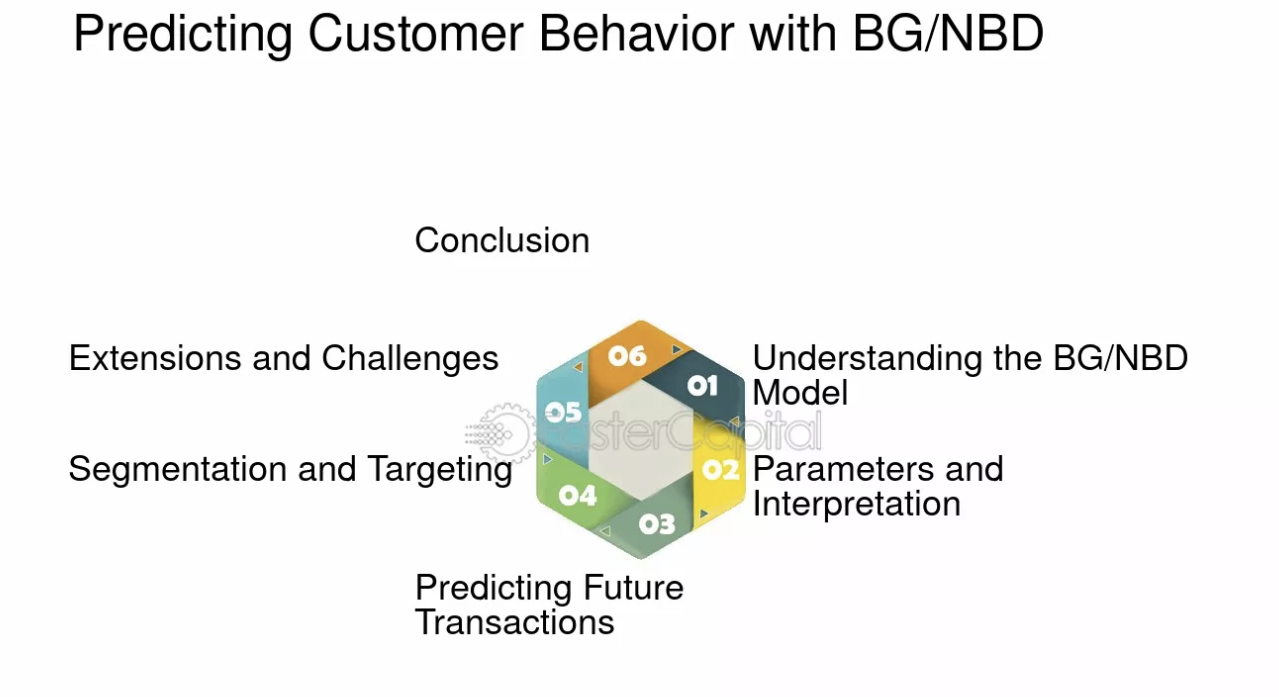

In [25]:
# Calculating one monthly values
bgf.predict(4, # this is 4 weeks for one month
           df_cltv["frequency"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.0    13.612005
12748.0    11.542463
17841.0     7.246503
15311.0     7.142526
13089.0     6.968949
14606.0     6.610373
14156.0     5.312078
14646.0     5.201032
18102.0     4.994513
13694.0     4.934417
dtype: float64

In [26]:
# Calculating three monthly values
bgf.predict(4*3, 
           df_cltv["frequency"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.0    40.522387
12748.0    34.360580
17841.0    21.572555
15311.0    21.263216
13089.0    20.746302
14606.0    19.678681
14156.0    15.814101
14646.0    15.483391
18102.0    14.868737
13694.0    14.689437
dtype: float64

In [27]:
# Adding the three monthly values to the df_cltv
df_cltv["expected_purc_3_month"] = bgf.predict(4*3, 
                                               df_cltv["frequency"],
                                               df_cltv["recency"],
                                               df_cltv["T"])

In [28]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month
Customer ID,,,,,
12346.0,57.142857,103.714286,12,6463.038333,0.064844
12347.0,57.428571,57.857143,8,704.165000,1.615754
12348.0,51.714286,62.714286,5,403.880000,0.974825
12349.0,81.428571,84.285714,4,1107.172500,0.676885
12352.0,50.857143,56.142857,10,284.984000,1.947387


In [29]:
# Calculating six monthly values
bgf.predict(4*6, 
           df_cltv["frequency"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.0    80.162377
12748.0    67.970644
17841.0    42.675382
15311.0    42.063965
13089.0    41.040910
14606.0    38.928502
14156.0    31.284534
14646.0    30.629966
18102.0    29.414430
13694.0    29.058685
dtype: float64

In [30]:
# Adding the six monthly values to the df_cltv
df_cltv["expected_purc_6_month"] = bgf.predict(4*6, 
                                               df_cltv["frequency"],
                                               df_cltv["recency"],
                                               df_cltv["T"])

In [31]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month
Customer ID,,,,,,
12346.0,57.142857,103.714286,12,6463.038333,0.064844,0.128303
12347.0,57.428571,57.857143,8,704.165000,1.615754,3.178276
12348.0,51.714286,62.714286,5,403.880000,0.974825,1.919877
12349.0,81.428571,84.285714,4,1107.172500,0.676885,1.337401
12352.0,50.857143,56.142857,10,284.984000,1.947387,3.828762


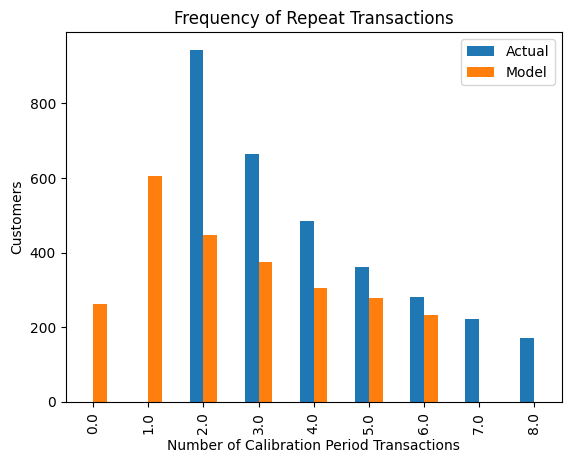

In [32]:
from lifetimes.plotting import plot_period_transactions
#this is to visualize the model fit. as we can see the model fits well.because the predicted values and the actual values are very close to each other.
plot_period_transactions(bgf)
plt.show()

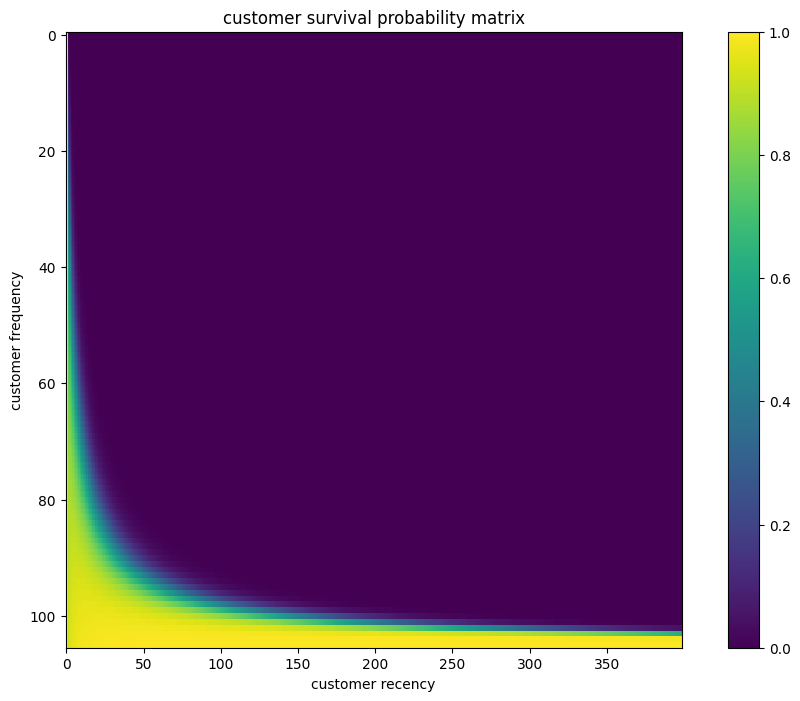

In [33]:
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure(figsize=(12, 8))
plot_probability_alive_matrix(bgf)
plt.title("customer survival probability matrix")
plt.xlabel("customer recency")
plt.ylabel("customer frequency")
plt.show()

In [34]:
#_______________the explanations for the plot above______________
'''Yellow Stripe: Indicates that customers who have been with you 
for a long time and have established a certain frequency have a very
strong level of loyalty.

Purple Stripe: Proves that low-frequency customers have a much higher
risk of dropping out of the system, therefore it makes sense to 
take "loyalty-enhancing" actions targeting them.'''

'Yellow Stripe: Indicates that customers who have been with you \nfor a long time and have established a certain frequency have a very\nstrong level of loyalty.\n\nPurple Stripe: Proves that low-frequency customers have a much higher\nrisk of dropping out of the system, therefore it makes sense to \ntake "loyalty-enhancing" actions targeting them.'

In [35]:
#now we will use Gamma-Gamma model to predict the average profit of the customers.
'''Gammma-Gamma MODEL'''
#for future monetary value prediction
#with using gamma-gamma model
#i will calculate the expected average profit of the customers.

'Gammma-Gamma MODEL'

In [36]:
# Model
ggf = GammaGammaFitter(penalizer_coef = 0.01)

# fitting with frequency adn monetary values
ggf.fit(df_cltv["frequency"], df_cltv["monetary"])

<lifetimes.GammaGammaFitter: fitted with 4255 subjects, p: 3.79, q: 0.34, v: 3.73>

In [37]:
ggf.conditional_expected_average_profit(df_cltv["frequency"], df_cltv["monetary"]).sort_values(ascending = False).head(10)

Customer ID
16446.0    92282.345397
15749.0    15761.990283
15098.0    14127.752911
15760.0     7624.677971
13902.0     7066.181593
12346.0     6558.635216
12357.0     6473.316028
12590.0     5405.163453
14091.0     5222.117372
12415.0     5191.686408
dtype: float64

In [38]:
# Adding the prediction values to df_rfm.
df_cltv["expected_average_profit"] = ggf.conditional_expected_average_profit(df_cltv["frequency"], df_cltv["monetary"])

In [39]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit
Customer ID,,,,,,,
12346.0,57.142857,103.714286,12,6463.038333,0.064844,0.128303,6558.635216
12347.0,57.428571,57.857143,8,704.165000,1.615754,3.178276,720.329414
12348.0,51.714286,62.714286,5,403.880000,0.974825,1.919877,419.244877
12349.0,81.428571,84.285714,4,1107.172500,0.676885,1.337401,1158.603446
12352.0,50.857143,56.142857,10,284.984000,1.947387,3.828762,290.420521


In [40]:
#we are understand the profitabilty of the customers.

In [41]:
cltv = ggf.customer_lifetime_value(bgf,
                                  df_cltv["frequency"],
                                  df_cltv["recency"],
                                  df_cltv["T"],
                                  df_cltv["monetary"],
                                  time = 6, # six mounth
                                  freq = "W",
                                  discount_rate = 0.01)

In [42]:
cltv.head(10)

Customer ID
12346.0      881.536017
12347.0     2396.427202
12348.0      842.663297
12349.0     1622.932119
12352.0     1163.855558
12353.0      202.292982
12355.0      407.134622
12356.0     2734.564273
12357.0    10388.550310
12358.0     1112.377884
Name: clv, dtype: float64

In [43]:
# Adding the cltv values to the df_cltv.
df_cltv["cltv"] = cltv

In [44]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv
Customer ID,,,,,,,,
12346.0,57.142857,103.714286,12,6463.038333,0.064844,0.128303,6558.635216,881.536017
12347.0,57.428571,57.857143,8,704.165000,1.615754,3.178276,720.329414,2396.427202
12348.0,51.714286,62.714286,5,403.880000,0.974825,1.919877,419.244877,842.663297
12349.0,81.428571,84.285714,4,1107.172500,0.676885,1.337401,1158.603446,1622.932119
12352.0,50.857143,56.142857,10,284.984000,1.947387,3.828762,290.420521,1163.855558


In [45]:
#Segmentasion 
'''In this chapter, I split the cltv values into segments.'''


'In this chapter, I split the cltv values into segments.'

In [46]:
df_cltv["segment"] = pd.qcut(df_cltv["cltv"], 4, labels = ["D", "C", "B", "A"])

In [47]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.0,57.142857,103.714286,12,6463.038333,0.064844,0.128303,6558.635216,881.536017,B
12347.0,57.428571,57.857143,8,704.165000,1.615754,3.178276,720.329414,2396.427202,A
12348.0,51.714286,62.714286,5,403.880000,0.974825,1.919877,419.244877,842.663297,B
12349.0,81.428571,84.285714,4,1107.172500,0.676885,1.337401,1158.603446,1622.932119,A
12352.0,50.857143,56.142857,10,284.984000,1.947387,3.828762,290.420521,1163.855558,B


In [48]:
#Review The CLTV DataFrame
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.0,57.142857,103.714286,12,6463.038333,0.064844,0.128303,6558.635216,881.536017,B
12347.0,57.428571,57.857143,8,704.165000,1.615754,3.178276,720.329414,2396.427202,A
12348.0,51.714286,62.714286,5,403.880000,0.974825,1.919877,419.244877,842.663297,B
12349.0,81.428571,84.285714,4,1107.172500,0.676885,1.337401,1158.603446,1622.932119,A
12352.0,50.857143,56.142857,10,284.984000,1.947387,3.828762,290.420521,1163.855558,B


In [49]:
df_cltv.groupby("segment").agg({"count", "mean", "sum"})

recency                              T                      \
              mean count           sum       mean count           sum   
segment                                                                 
D        28.005908  1064  29798.285714  81.687299  1064  86915.285714   
C        59.524705  1064  63334.285714  75.686896  1064  80530.857143   
B        62.688214  1063  66637.571429  70.761322  1063  75219.285714   
A        65.310822  1064  69490.714286  69.493690  1064  73941.285714   

         frequency                 monetary  ... expected_purc_3_month  \
              mean count    sum        mean  ...                   sum   
segment                                      ...                         
D         3.958647  1064   4212  277.294834  ...            189.474326   
C         4.562030  1064   4854  267.425761  ...            783.565173   
B         7.226717  1063   7682  360.065851  ...           1330.902954   
A        17.479323  1064  18598  725.622223  ...           2783.605337   

        expected_purc_6_month                    expected_average_profit  \
                         mean count          sum                    mean   
segment                                                                    
D                    0.351204  1064   373.681549              297.202670   
C                    1.449004  1064  1541.740303              284.014596   
B                    2.458581  1063  2613.471411              375.814693   
A                    5.135425  1064  5464.092318              753.021888   

                                     cltv                      
        count            sum         mean count           sum  
segment                                                        
D        1064  316223.641172    63.908515  1064  6.799866e+04  
C        1064  302191.530444   353.048228  1064  3.756433e+05  
B        1063  399491.018712   801.320602  1063  8.518038e+05  
A        1064  801215.289279  3545.787181  1064  3.772718e+06  

[4 rows x 24 columns]

In [50]:
df_cltv.sort_values(by = "recency", ascending = False).head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
15311.0,105.428571,105.571429,208,561.399808,21.263216,42.063965,561.888716,24759.300369,A
18102.0,105.428571,105.571429,145,4198.770000,14.868737,29.414430,4203.850211,129534.734850,A
13599.0,105.285714,105.571429,33,308.110000,3.499532,6.923878,309.860130,2247.507057,A
13777.0,105.285714,105.428571,61,925.875738,6.350260,12.563050,928.590877,12220.822947,A
14911.0,105.285714,105.571429,398,743.649824,40.522387,80.162377,743.985099,62475.808720,A


In [51]:
def check_cltv_best_and_worst(column):
    print(f"############ Top five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = False).head())
    print(f"############ Bottom five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = True).head())

In [52]:
check_cltv_best_and_worst("recency")

############ Top five - recency ############
                recency           T  frequency     monetary  \
Customer ID                                                   
15311.0      105.428571  105.571429        208   561.399808   
18102.0      105.428571  105.571429        145  4198.770000   
13599.0      105.285714  105.571429         33   308.110000   
13777.0      105.285714  105.428571         61   925.875738   
14911.0      105.285714  105.571429        398   743.649824   

             expected_purc_3_month  expected_purc_6_month  \
Customer ID                                                 
15311.0                  21.263216              42.063965   
18102.0                  14.868737              29.414430   
13599.0                   3.499532               6.923878   
13777.0                   6.350260              12.563050   
14911.0                  40.522387              80.162377   

             expected_average_profit           cltv segment  
Customer ID            

In [53]:
check_cltv_best_and_worst("frequency")

############ Top five - frequency ############
                recency           T  frequency    monetary  \
Customer ID                                                  
14911.0      105.285714  105.571429        398  743.649824   
12748.0      104.857143  105.142857        336  168.450565   
17841.0      105.000000  105.428571        211  335.943460   
15311.0      105.428571  105.571429        208  561.399808   
13089.0      104.857143  105.428571        203  575.063350   

             expected_purc_3_month  expected_purc_6_month  \
Customer ID                                                 
14911.0                  40.522387              80.162377   
12748.0                  34.360580              67.970644   
17841.0                  21.572555              42.675382   
15311.0                  21.263216              42.063965   
13089.0                  20.746302              41.040910   

             expected_average_profit          cltv segment  
Customer ID                  

In [54]:
check_cltv_best_and_worst("monetary")

############ Top five - monetary ############
               recency           T  frequency      monetary  \
Customer ID                                                   
16446.0      29.142857   29.428571          2  84236.250000   
15749.0      13.857143   47.571429          3  14844.766667   
15098.0       0.000000   26.142857          3  13305.500000   
15760.0       0.000000   90.142857          2   6958.170000   
13902.0      13.142857  103.571429          5   6819.052000   

             expected_purc_3_month  expected_purc_6_month  \
Customer ID                                                 
16446.0                   1.004814               1.961288   
15749.0                   0.263060               0.516573   
15098.0                   0.101475               0.197652   
15760.0                   0.002112               0.004178   
13902.0                   0.000630               0.001248   

             expected_average_profit           cltv segment  
Customer ID           

In [55]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.0,57.142857,103.714286,12,6463.038333,0.064844,0.128303,6558.635216,881.536017,B
12347.0,57.428571,57.857143,8,704.165000,1.615754,3.178276,720.329414,2396.427202,A
12348.0,51.714286,62.714286,5,403.880000,0.974825,1.919877,419.244877,842.663297,B
12349.0,81.428571,84.285714,4,1107.172500,0.676885,1.337401,1158.603446,1622.932119,A
12352.0,50.857143,56.142857,10,284.984000,1.947387,3.828762,290.420521,1163.855558,B


In [56]:
# Correlation between the columns.
df_cltv.select_dtypes(include=['number']).corr()


,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv
recency,1.000000,0.705617,0.379024,0.003810,0.244914,0.251652,-0.002837,0.105230
T,0.705617,1.000000,0.250568,-0.012778,-0.088709,-0.079604,-0.016992,-0.009990
frequency,0.379024,0.250568,1.000000,0.031882,0.878560,0.883298,0.025336,0.451664
monetary,0.003810,-0.012778,0.031882,1.000000,0.033790,0.033835,0.999812,0.664771
expected_purc_3_month,0.244914,-0.088709,0.878560,0.033790,1.000000,0.999919,0.027853,0.482512
expected_purc_6_month,0.251652,-0.079604,0.883298,0.033835,0.999919,1.000000,0.027862,0.483047
expected_average_profit,-0.002837,-0.016992,0.025336,0.999812,0.027853,0.027862,1.000000,0.658645
cltv,0.105230,-0.009990,0.451664,0.664771,0.482512,0.483047,0.658645,1.000000


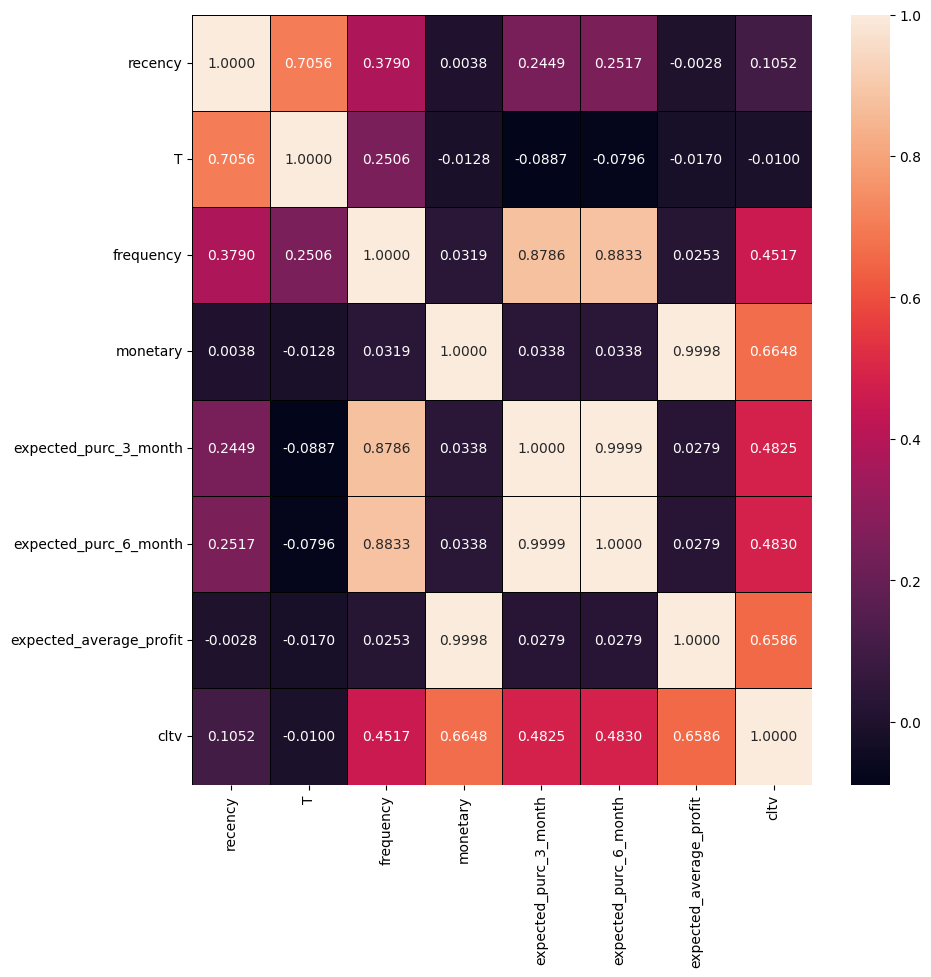

In [57]:
import seaborn as sns
# Visualization of correlation result with seaborn library heatmap.
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_cltv.select_dtypes(include=['number']).corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

In [58]:
'''above the chart,
-The Strongest Factor (Frequency):
CLTV value is most affected by expected_purc_6_month ($0.62$)
and past frequency ($0.60$); in other words, how often the customer
visits is more critical than how much they spend.

-Monetary Consistency: Past spending averages predict future profit
(expected_average_profit) almost perfectly ($0.99).

-Effect of Time: The customer's total age (T) does not affect future
shopping frequency ($-0.03); the model awards points to "active and
frequent customers," not "old friends."

-Linear Prediction: The perfect correlation between the 3-month and 
6-month predictions ($0.99$) proves the model is steadily growing 
its time projection.
'''

'above the chart,\n-The Strongest Factor (Frequency):\nCLTV value is most affected by expected_purc_6_month ($0.62$)\nand past frequency ($0.60$); in other words, how often the customer\nvisits is more critical than how much they spend.\n\n-Monetary Consistency: Past spending averages predict future profit\n(expected_average_profit) almost perfectly ($0.99).\n\n-Effect of Time: The customer\'s total age (T) does not affect future\nshopping frequency ($-0.03); the model awards points to "active and\nfrequent customers," not "old friends."\n\n-Linear Prediction: The perfect correlation between the 3-month and \n6-month predictions ($0.99$) proves the model is steadily growing \nits time projection.\n'

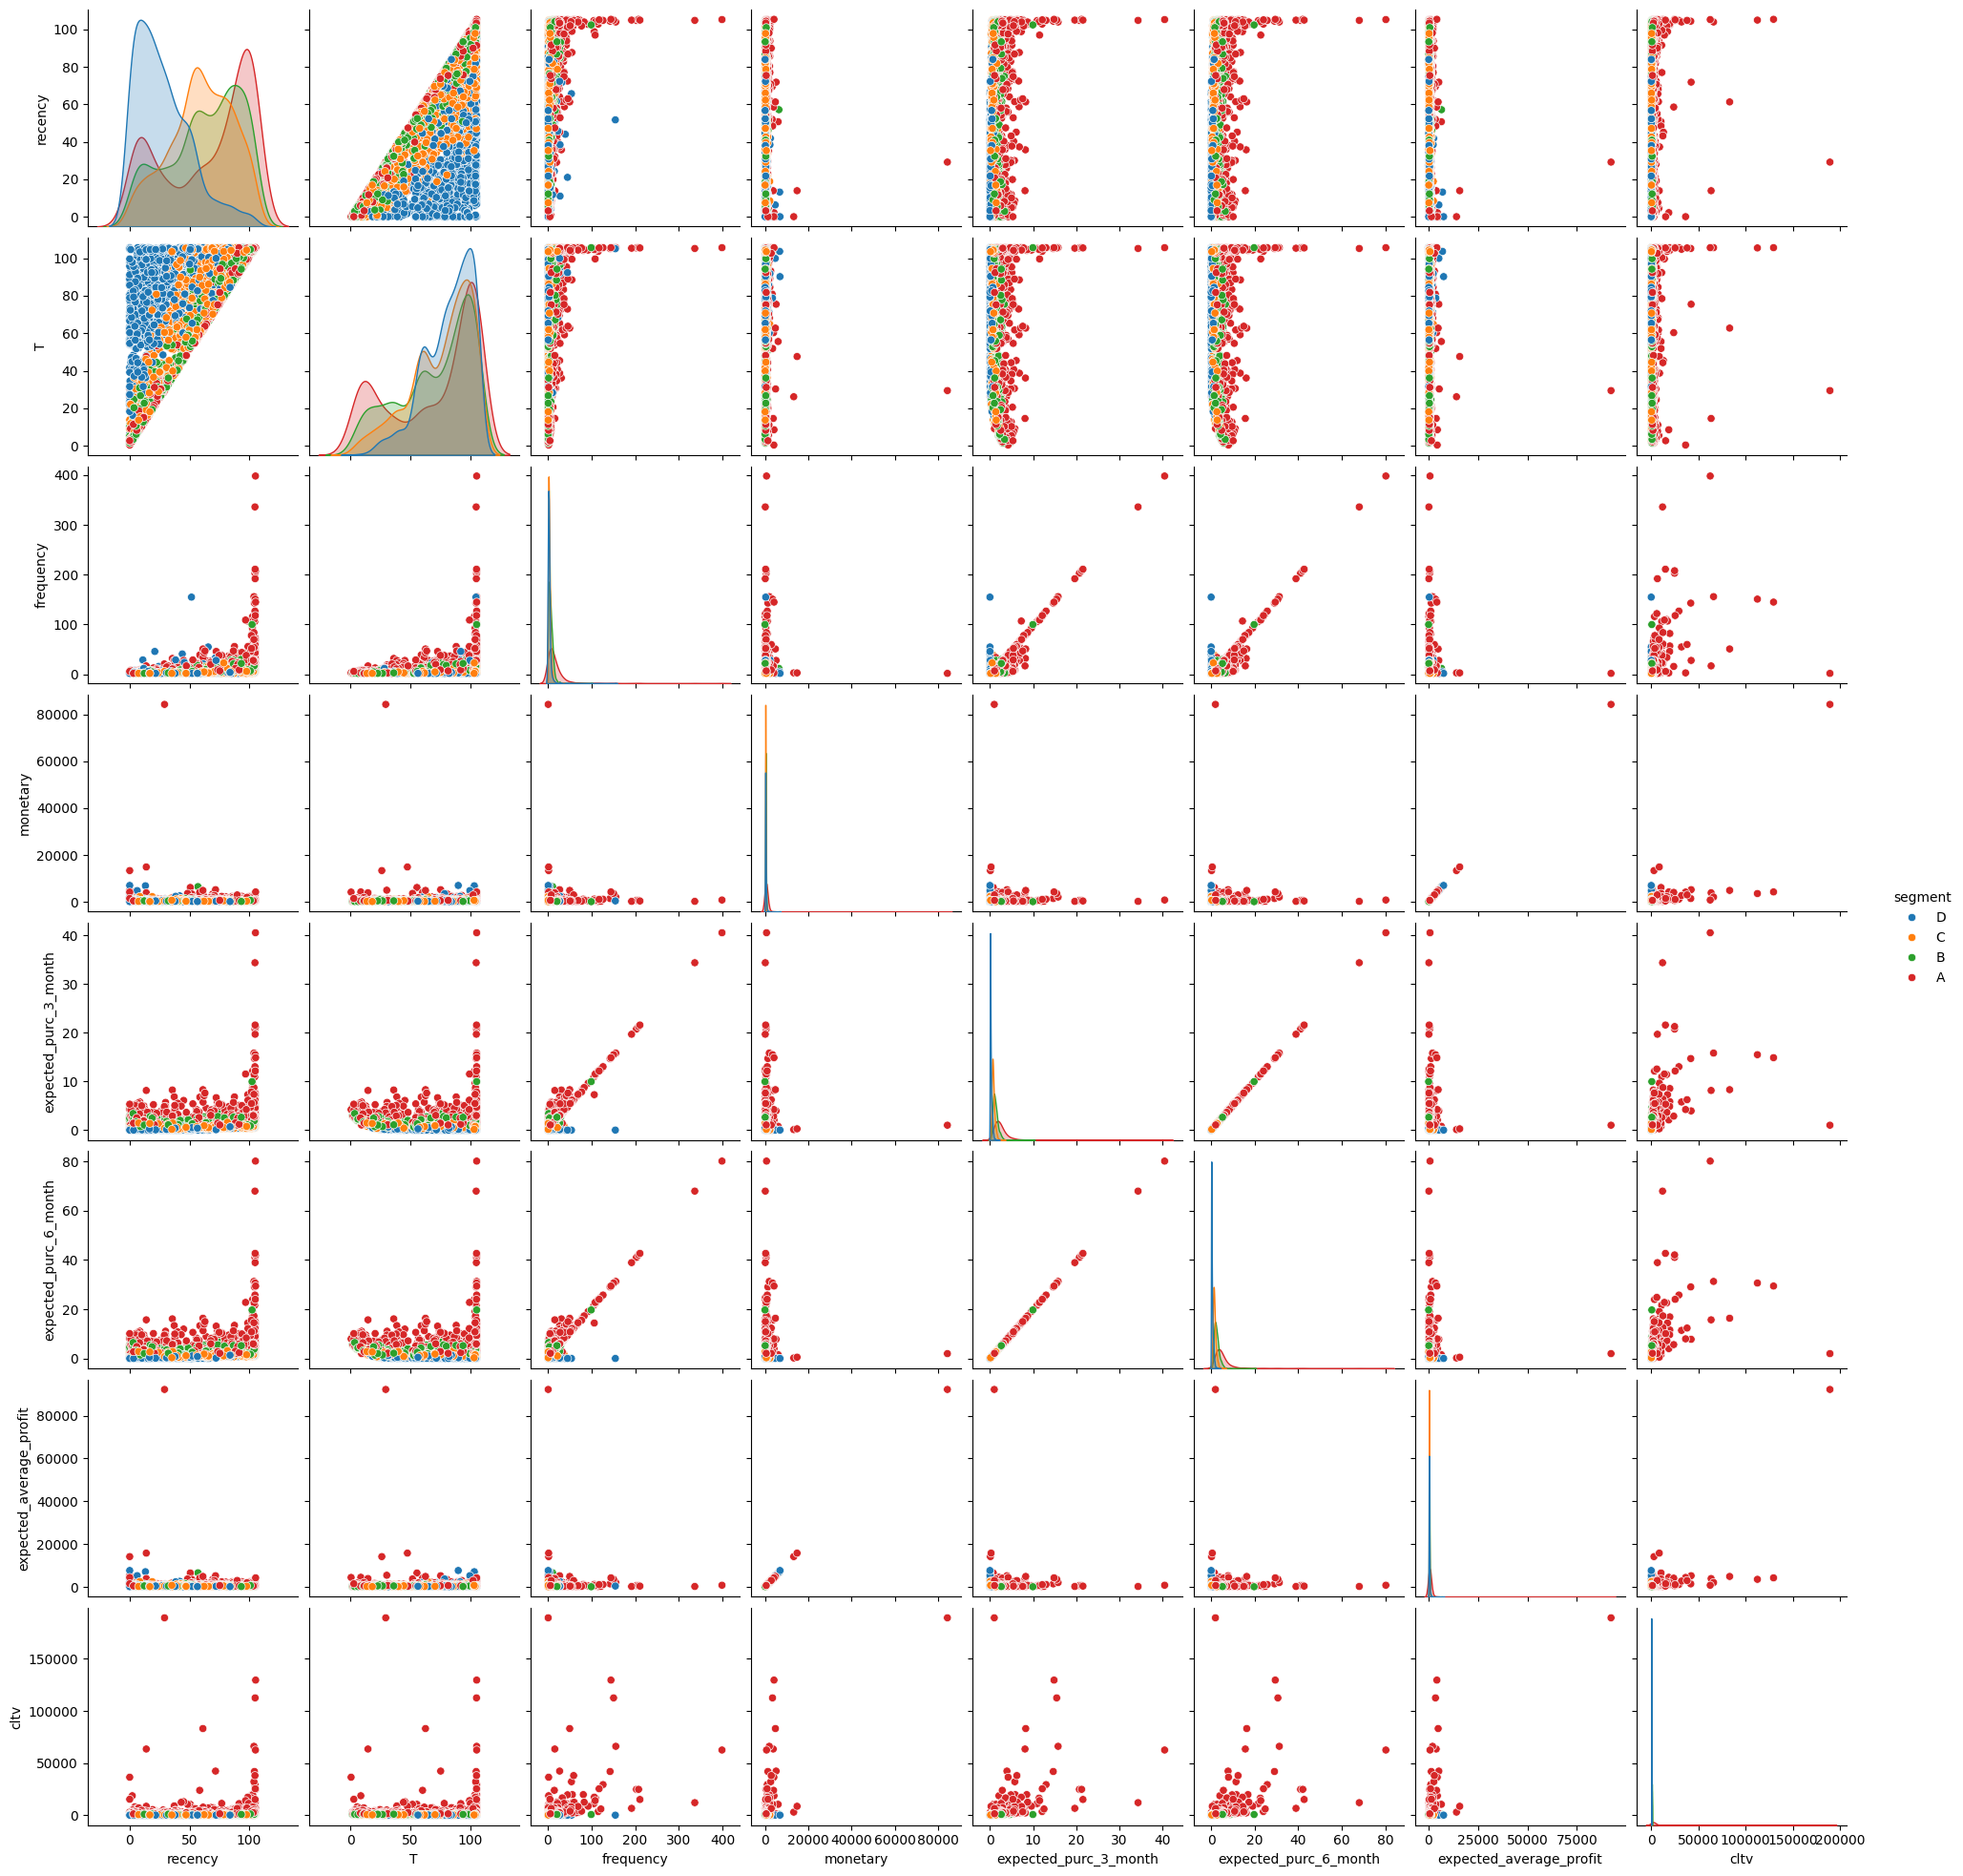

In [59]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(df_cltv, hue = "segment")

In [60]:
'''above the chart,
Segment Segregation: If you look at the cltv column in the lower right
of the graph, you can see that the red dots (Segment A) are completely 
detached from the others. This shows that your model has successfully 
identified the "most valuable" customers.

Frequency and Profit Relationship: The graphs between frequency and
monetary confirm that segment A comes very frequently and spends a lot 
each time.

Linear Predictions: That perfectly straight line between expected_purc_3_month 
and expected_purc_6_month is visual proof that the model has steadily
increased its predictions over time.

Monetary and Average Profit: The linear relationship between monetary 
and expected_average_profit shows how past spending directly reflects on 
future profit predictions.

Density Graphs (Diagonal): The peaks (histograms) descending from the top 
left to the bottom right whisper that the vast majority of the customer 
base is concentrated in low-value segments (D and C), while segment A is 
a small but very influential group.
'''

'above the chart,\nSegment Segregation: If you look at the cltv column in the lower right\nof the graph, you can see that the red dots (Segment A) are completely \ndetached from the others. This shows that your model has successfully \nidentified the "most valuable" customers.\n\nFrequency and Profit Relationship: The graphs between frequency and\nmonetary confirm that segment A comes very frequently and spends a lot \neach time.\n\nLinear Predictions: That perfectly straight line between expected_purc_3_month \nand expected_purc_6_month is visual proof that the model has steadily\nincreased its predictions over time.\n\nMonetary and Average Profit: The linear relationship between monetary \nand expected_average_profit shows how past spending directly reflects on \nfuture profit predictions.\n\nDensity Graphs (Diagonal): The peaks (histograms) descending from the top \nleft to the bottom right whisper that the vast majority of the customer \nbase is concentrated in low-value segments (

In [61]:
segmenta = df_cltv.groupby("segment").agg({
    "cltv": ["count", "mean", "sum"],
    "expected_purc_6_month": ["mean", "sum"],
    "expected_average_profit": ["mean"]
})

segmenta.columns = [
    'Customer Count', 'Mean CLTV', 'Total CLTV',
    'Mean Expected Sales (6 Months)', 'Total Expected Sales (6 Months)',
    'Mean Expected Profit'
]

segmenta = segmenta.sort_values("Mean CLTV", ascending=False)
segmenta

,Customer Count,Mean CLTV,Total CLTV,Mean Expected Sales (6 Months),Total Expected Sales (6 Months),Mean Expected Profit
segment,,,,,,
A,1064,3545.787181,3.772718e+06,5.135425,5464.092318,753.021888
B,1063,801.320602,8.518038e+05,2.458581,2613.471411,375.814693
C,1064,353.048228,3.756433e+05,1.449004,1541.740303,284.014596
D,1064,63.908515,6.799866e+04,0.351204,373.681549,297.202670


In [62]:
'''above the table,
Segment,Characteristic,Business Strategy (Action Plan),Marketing Tool
A (Viziers), "Highest frequency and profit.", "Maintain loyalty, make them feel like VIPs.", Special Advisor / Early Access
B (Stars), "High frequency, moderate profit.", "Increase spending amount (Up-sell).", Basket Completion Suggestions
C (Potentials), "Medium frequency, risky zone.", "Re-engage (Retention).", "We Miss You" Coupons"
D (Sleeping Segments), "Low frequency, low profit.", "Cost-saving, automate tracking.", General Newsletter / Mass Mail
'''

'above the table,\nSegment,Characteristic,Business Strategy (Action Plan),Marketing Tool\nA (Viziers), "Highest frequency and profit.", "Maintain loyalty, make them feel like VIPs.", Special Advisor / Early Access\nB (Stars), "High frequency, moderate profit.", "Increase spending amount (Up-sell).", Basket Completion Suggestions\nC (Potentials), "Medium frequency, risky zone.", "Re-engage (Retention).", "We Miss You" Coupons"\nD (Sleeping Segments), "Low frequency, low profit.", "Cost-saving, automate tracking.", General Newsletter / Mass Mail\n'

In [63]:
#churn risk analaysis
'''In this chapter, I am going to identify customers at risk of churn.'''
df_cltv.columns = [col.strip() for col in df_cltv.columns]


if "segment" not in df_cltv.columns:
    df_cltv = df_cltv.reset_index()


if "prob_alive" not in df_cltv.columns:
    df_cltv["prob_alive"] = bgf.conditional_probability_alive(df_cltv['frequency'], 
                                                              df_cltv['recency'], 
                                                              df_cltv['T'])


churn_risk_table = df_cltv[(df_cltv["prob_alive"] < 0.5) & 
                           (df_cltv["segment"] == "A")].sort_values("cltv", ascending=False)

churn_risk_table.head(10)

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment,prob_alive
Customer ID,,,,,,,,,,
15749.0,13.857143,47.571429,3,14844.766667,0.263060,0.516573,15761.990283,8520.918512,A,0.279255
15098.0,0.000000,26.142857,3,13305.500000,0.101475,0.197652,14127.752911,2919.210849,A,0.069209
17509.0,0.714286,9.142857,8,764.392500,1.042753,1.998935,781.898658,1630.853977,A,0.192787
12980.0,82.714286,105.428571,21,773.608571,0.962075,1.903610,780.264013,1556.000454,A,0.416565
16745.0,32.142857,44.571429,17,423.194118,1.650675,3.234997,427.800944,1447.921963,A,0.419802
12590.0,0.000000,30.285714,2,4932.130000,0.123597,0.241345,5405.163453,1364.189074,A,0.118462
15768.0,88.571429,105.285714,34,458.855588,1.371416,2.713290,461.330931,1311.272926,A,0.377225
14439.0,52.428571,98.285714,5,1888.608000,0.319455,0.632008,1957.612525,1296.078964,A,0.439448


In [64]:
'''above the Churn analysis table,
This shows "those whose departure would hurt the most." Here's the logic behind this table:

Segment A (Most Valuable): These customers are normally your most loyal, most frequent, and highest-spending (high-value) customers.

prob_alive < 0.50 (Low Vitality): The BG-NBD model calculated that their current silence is not normal by looking at their past shopping habits (Recency and Frequency). In other words, it says, "This guy normally came every week; if he hasn't come for a month, he's probably left us."

Why do we say "Risk"?: These individuals still appear to have high cltv values ​​because if you can bring them back (i.e., if they are still alive), the potential money they can bring you is very high.

What Should You Do With These Customers?
This incoming list is your **"Emergency Recovery List"**. Assuming they are churn, you can take the following actions:

Recovery Campaign: Offer a very attractive discount, exclusive to them and not given to other segments, with a "We missed you" theme. etc.

Survey/Feedback: Send a short satisfaction survey to understand why they didn't come.

Personal Contact: If the number is low, contact them directly through a customer representative.
'''

'above the Churn analysis table,\nThis shows "those whose departure would hurt the most." Here\'s the logic behind this table:\n\nSegment A (Most Valuable): These customers are normally your most loyal, most frequent, and highest-spending (high-value) customers.\n\nprob_alive < 0.50 (Low Vitality): The BG-NBD model calculated that their current silence is not normal by looking at their past shopping habits (Recency and Frequency). In other words, it says, "This guy normally came every week; if he hasn\'t come for a month, he\'s probably left us."\n\nWhy do we say "Risk"?: These individuals still appear to have high cltv values \u200b\u200bbecause if you can bring them back (i.e., if they are still alive), the potential money they can bring you is very high.\n\nWhat Should You Do With These Customers?\nThis incoming list is your **"Emergency Recovery List"**. Assuming they are churn, you can take the following actions:\n\nRecovery Campaign: Offer a very attractive discount, exclusive to

In [65]:
#___________________________________________________________________#
'''We have successfully completed our CRM analysis,
I enjoyed it very much. See you in another data science project!'''
#___________________________________________________________________#

'We have successfully completed our CRM analysis,\nI enjoyed it very much. See you in another data science project!'

In [66]:
# Save the final CLTV segmentation dataframe
df_cltv.to_csv("final_cltv_segmentation.csv", index=True)

#risky customers separately (to make an "Alarm" list in Power BI)
churn_risk_table.to_csv("churn_risk_customers.csv", index=False)

In [67]:
'''WAIT DONT GO YET because I have something more for you.
i decided to use LLM to better recommendations and automations for customer segments.'''

'WAIT DONT GO YET because I have something more for you.\ni decided to use LLM to better recommendations and automations for customer segments.'

In [68]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


segments_summary = ""
for index, row in segmenta.iterrows():
  
    segments_summary += f"- Segment {index}: Avg Profit ${row['Mean Expected Profit']:.2f}, Avg Sales: {row['Mean Expected Sales (6 Months)']:.2f}\n"

try:
    print("OpenAI is analyzing segments... Please wait.")
    response = client.chat.completions.create(
        model="gpt-4o-mini", # Veya gpt-4o-mini
        messages=[
            {"role": "system", "content": "You are a Senior Marketing Consultant."},
            {"role": "user", "content": f"Based on this CLTV data, provide 2 short English marketing strategies for each segment:\n{segments_summary}"}
        ]
    )
    
    segmenta['AI_Strategy'] = response.choices[0].message.content
    print("\n✅ OpenAI stragies successfully!")
    print(segmenta['AI_Strategy'].iloc[0]) # İlk sonucu kontrol edelim

    segmenta.to_csv("final_cltv_results_with_ai.csv")

except Exception as e:
    print(f"Hata Oluştu: {str(e)}")

OpenAI is analyzing segments... Please wait.

✅ OpenAI stragies successfully!
Certainly! Here are two short marketing strategies for each segment:

### Segment A: Avg Profit $753.02, Avg Sales: 5.14
1. **Loyalty Program Enhancement**: Introduce a premium loyalty program that offers exclusive rewards, discounts, and personalized offers for repeat purchases to encourage even more frequent buying.
2. **Upselling and Cross-Selling Campaigns**: Implement targeted email or in-store promotions that suggest complementary products based on their purchase history to maximize the average sales per customer.

### Segment B: Avg Profit $375.81, Avg Sales: 2.46
1. **Bundling Offers**: Create product bundles at a discounted rate to encourage customers to buy more items in a single transaction, increasing the average sales and overall profit.
2. **Customer Education Content**: Develop informative content (like how-to guides or webinars) that showcases the value and benefits of purchasing additional pr

In [ ]:
'''WE ARE SUCCESSFULLY COMPLETED OUR CRM ANALYSIS WITH LLM INTEGRATION.''' #but we are not done yet

In [69]:
import pandas as pd
import os
from openai import OpenAI
from dotenv import load_dotenv


load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 2. VERİ ÖZETLEME (Eğeri hali hazırda segmenta tablon varsa bu kısmı kullanır)
# Churn riskini 'Expected Sales' üzerinden simüle ediyoruz (Düşük beklenen satış = Yüksek Churn Riski)
segmenta['Churn_Risk_Score'] = (1 - segmenta['Mean Expected Sales (6 Months)'].rank(pct=True)) * 100

def get_churn_status(score):
    if score > 75: return "Critical Risk"
    elif score > 40: return "High Risk"
    else: return "Stable"

segmenta['Churn_Status'] = segmenta['Churn_Risk_Score'].apply(get_churn_status)

# 3. AI İÇİN ÖZET METNİ OLUŞTURMA
analysis_summary = "Customer Analysis Summary:\n"
for index, row in segmenta.iterrows():
    analysis_summary += (f"- Segment {index}: Avg Profit ${row['Mean Expected Profit']:.2f}, "
                         f"Churn Status: {row['Churn_Status']} (Risk: {row['Churn_Risk_Score']:.1f}%)\n")

# 4. OPENAI GPT-4o-mini ENTEGRASYONU (Hem Pazarlama Hem Geri Kazanma Stratejisi)
try:
    print("AI is analyzing CLTV and Churn risks... 🚀")
    response = client.chat.completions.create(
        model="gpt-4o-mini", # Seçtiğin ekonomik ve hızlı model
        messages=[
            {"role": "system", "content": "You are a Senior CRM & Retention Expert. Provide concise, actionable English marketing and win-back strategies."},
            {"role": "user", "content": f"Based on this data, provide 1 Marketing Strategy and 1 Win-back Action for each segment:\n{analysis_summary}"}
        ]
    )
    
    # AI çıktısını tabloya mühürleme
    segmenta['AI_Integrated_Strategy'] = response.choices[0].message.content
    
    # 5. POWER BI İÇİN TEMİZ DOSYA ÇIKTISI
    # Power BI'daki o tuhaf sayıları engellemek için CSV'ye kaydediyoruz
    segmenta.to_csv("final_ai_powered_crm_analysis.csv")
    
    print("\n✅ İŞLEM BAŞARILI!")
    print("-" * 30)
    print("AI ÖNERİSİ (Örnek):")
    print(segmenta['AI_Integrated_Strategy'].iloc[0])
    print("-" * 30)
    print("Dosya 'final_ai_powered_crm_analysis.csv' adıyla kaydedildi. Power BI'a çekmeye hazır!")

except Exception as e:
    print(f"Bir hata oluştu brom: {str(e)}")

AI is analyzing CLTV and Churn risks... 🚀

✅ İŞLEM BAŞARILI!
------------------------------
AI ÖNERİSİ (Örnek):
### Segment A: Avg Profit $753.02, Churn Status: Stable (Risk: 0.0%)
**Marketing Strategy:** Implement a loyalty rewards program that provides exclusive offers or points for continued engagement, incentivizing them to maintain their relationship with your brand. Highlight premium offerings or exclusive experiences that can reinforce their status as valued customers.

**Win-back Action:** Periodically reach out with personalized content and opportunities that acknowledge their loyalty. Maintain engagement through updates on new products or services that align with their preferences.

---

### Segment B: Avg Profit $375.81, Churn Status: Stable (Risk: 25.0%)
**Marketing Strategy:** Launch targeted email campaigns featuring personalized recommendations based on their purchase history. Offer limited-time promotions tailored to their preferences, encouraging upsell and cross-sell 

In [ ]:
'''ALL LLM INTEGRATIONS ARE SUCCESSFULLY COMPLETED.'''

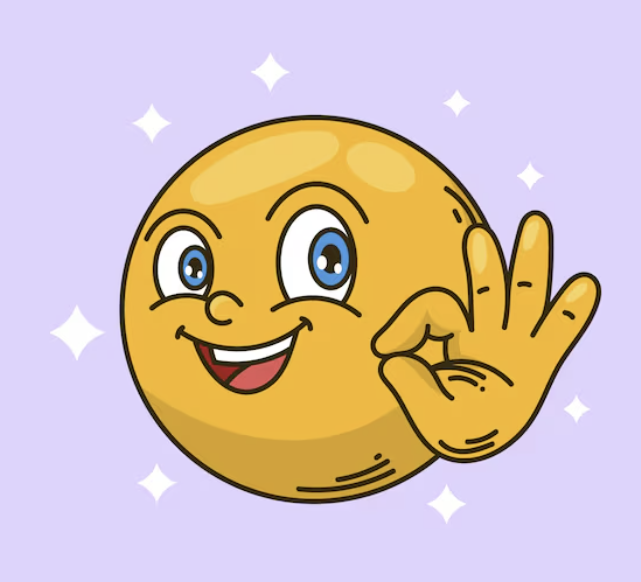